In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from matplotlib.colors import BoundaryNorm
import cartopy.crs as ccrs
import cmocean

from anemoi.datasets import open_dataset

In [2]:
plt.style.use("~/nice.mplstyle")

In [3]:
def open_nested(trim_edge=0, min_distance_km=0):
    
    data_dir = "/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/data"
    return open_dataset(
        cutout=[
            {"dataset": f"{data_dir}/hrrr.zarr", "trim_edge": trim_edge},
            f"{data_dir}/gfs.zarr",
        ],
        adjust="all",
        min_distance_km=min_distance_km,
    )

In [4]:
trim = 0

ads = open_nested(trim_edge=trim, min_distance_km=0)

Dataset /pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/data/hrrr.zarr has missing dates
Dataset /pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/data/gfs.zarr has missing dates


In [49]:
hds = xr.open_zarr("/pscratch/sd/t/timothys/nested-eagle/native/baselines/hrrr-forecasts/hrrr.forecasts.zarr/")

/tmp/ipykernel_2124709/1572049358.py:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  hds = xr.open_zarr("/pscratch/sd/t/timothys/nested-eagle/native/baselines/hrrr-forecasts/hrrr.forecasts.zarr/")


In [7]:
all_kwargs = {
    "accum_tp": get_precip_kwargs(),
    "t_surface": {"cmap": "cmo.thermal", "vmin": -10, "vmax": 30},
    "t2m": {"cmap": "cmo.thermal", "vmin": -10, "vmax": 30},
    "sh2": {"cmap": "cmo.haline_r", "vmin": 0, "vmax": 0.025},
    "u10": {"cmap": "cmo.balance", "vmin": -20, "vmax": 20},
    "v10": {"cmap": "cmo.balance", "vmin": -20, "vmax": 20},
}

In [56]:
#gfs = open_dataset("/pscratch/sd/t/timothys/anemoi-house/gfs/0.25-degree/data/gfs.zarr")
gfs = open_dataset("/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/data/gfs.zarr")

Dataset /pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/data/gfs.zarr has missing dates


In [50]:
def draw_box(ax, **kwargs):

    lons = hds.longitude.values
    lats = hds.latitude.values

    n_x = lons.shape[1]
    n_y = lons.shape[0]

    xidx = np.arange(0, n_x, 10)
    if xidx[-1] != n_x - 1:
        xidx = np.append(xidx, n_x - 1)
    yidx = np.arange(0, n_y, 10)
    if yidx[-1] != n_y - 1:
        yidx = np.append(yidx, n_y - 1)

    kw = {
        "color": "gray",
        "transform": ccrs.PlateCarree(),
        "lw": 1,
        "alpha": .8,
    }
    kw.update(kwargs)

    for idx in [0, -1]:
        ax.plot(lons[yidx, idx], lats[yidx, idx], **kw)
        ax.plot(lons[idx, xidx], lats[idx, xidx], **kw)

In [96]:
def plot_trimdict(date, varname, theds, mode="nested"):
    fig, ax = plt.subplots(
        1,
        1,
        figsize=(5, 5),
        subplot_kw={"projection": ccrs.Orthographic(central_longitude=-120, central_latitude=20)},
    )

    kwargs = all_kwargs[varname].copy()
    cbar_kwargs = kwargs.pop("cbar_kwargs", {})
    offset = -273.15 if varname in ("t_surface", "t2m") else 0

    itime = theds.to_index(date=date, variable=0)[0]
    ivar = theds.variables.index(varname)
    if mode=="nested":
        n_cutout = theds.grids[0]
        for i, (slc,s) in enumerate(zip(
            [slice(None, n_cutout), slice(n_cutout, None)],
            [1/4, 15],
        )):
            pp = ax.scatter(
                theds.longitudes[slc],
                theds.latitudes[slc],
                c=theds[itime, ivar, 0, slc]+offset,
                s=s,
                transform=ccrs.PlateCarree(),
                **kwargs,
            )
        draw_box(ax)
    elif mode == "global":
        ax.scatter(
            theds.longitudes,
            theds.latitudes,
            c=theds[itime, ivar, 0, :]+offset,
            s=15,
            transform=ccrs.PlateCarree(),
            **kwargs,
        )
    elif mode == "cutout":
        n_cutout = theds.grids[0]
        for i, (slc,s) in enumerate(zip(
            [slice(n_cutout, None)],
            [15],
        )):
            pp = ax.scatter(
                theds.longitudes[slc],
                theds.latitudes[slc],
                c=theds[itime, ivar, 0, slc]+offset,
                s=s,
                transform=ccrs.PlateCarree(),
                **kwargs,
            )
    elif mode=="cutout_r":
        n_cutout = theds.grids[0]
        for i, (slc,s) in enumerate(zip(
            [slice(None, n_cutout)],
            [1],
        )):
            pp = ax.scatter(
                theds.longitudes[slc],
                theds.latitudes[slc],
                c=theds[itime, ivar, 0, slc]+offset,
                s=s,
                transform=ccrs.PlateCarree(),
                **kwargs,
            )
            ax.axis("off")
    elif mode=="lamloss":
        n_cutout = theds.grids[0]
        for i, (slc,s,ff) in enumerate(zip(
            [slice(None, n_cutout), slice(n_cutout, None)],
            [1/4, 15],
            [kwargs["vmin"], kwargs["vmax"]]
        )):
            pp = ax.scatter(
                theds.longitudes[slc],
                theds.latitudes[slc],
                c=ff*np.ones_like(theds[itime, ivar, 0, slc]),
                s=s,
                transform=ccrs.PlateCarree(),
                **kwargs,
            )
    #ax.set_extent([-150, 80, 0, 80], crs=ccrs.PlateCarree())
    #ax.set(title=f"Trim = {trim}" if trim != "GFS" else "GFS Analysis")
    
    #plt.colorbar(pp, ax=ax, orientation="horizontal", shrink=.8, pad=0.05, label=varname, **cbar_kwargs)
    return fig, ax

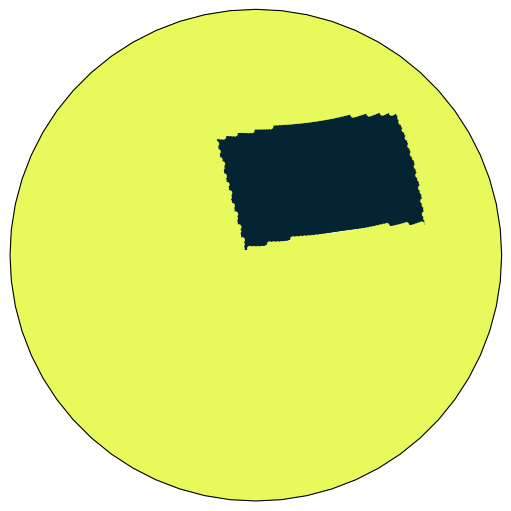

In [99]:
fig, ax = plot_trimdict(date="2023-03-10T00", varname="t2m", theds=ads, mode="lamloss")
fig.savefig("lamloss.jpeg", dpi=300, bbox_inches="tight")

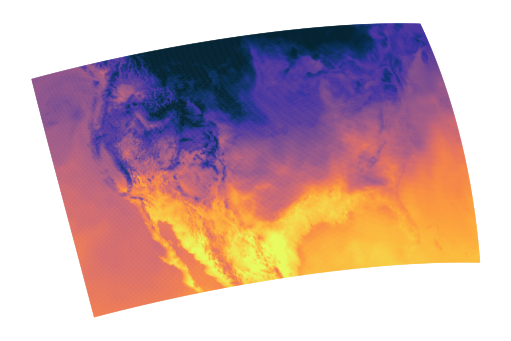

In [83]:
fig, ax = plot_trimdict(date="2023-03-10T00", varname="t2m", theds=ads, mode="cutout_r")
fig.savefig("cutout_r.jpeg", dpi=300, bbox_inches="tight")

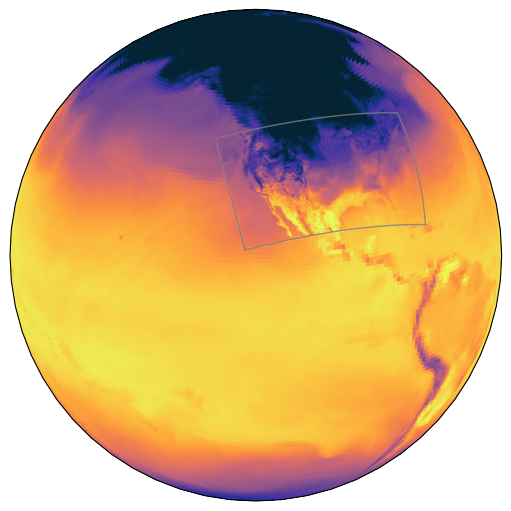

In [84]:
fig, ax = plot_trimdict(date="2023-03-10T00", varname="t2m", theds=ads, mode="nested")
fig.savefig("nested.jpeg", dpi=300, bbox_inches="tight")

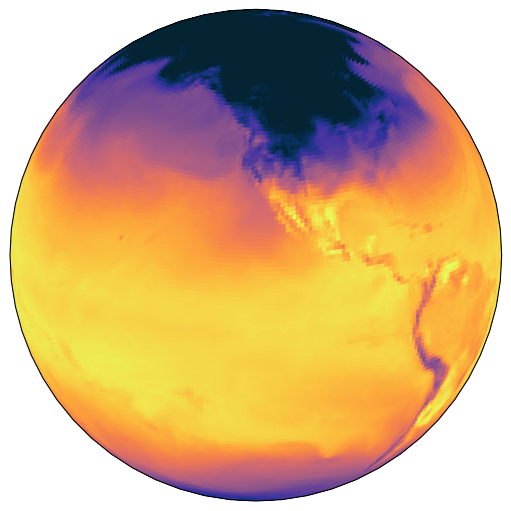

In [85]:
fig, ax = plot_trimdict(date="2023-03-10T00", varname="t2m", theds=gfs, mode="global")
fig.savefig("global.jpeg", dpi=300, bbox_inches="tight")

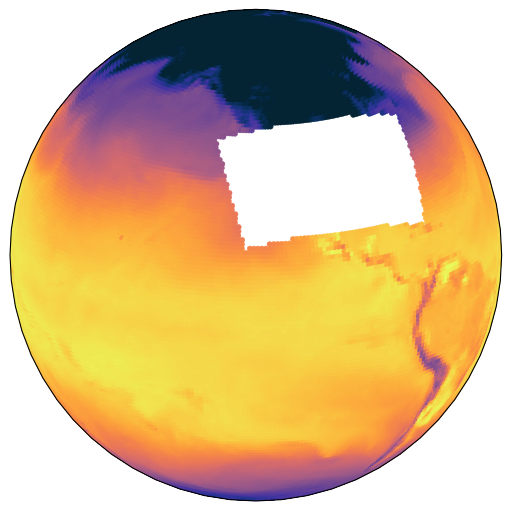

In [86]:
fig, ax = plot_trimdict(date="2023-03-10T00", varname="t2m", theds=ads, mode="cutout")
fig.savefig("cutout.jpeg", dpi=300, bbox_inches="tight")